Nb nodes: 3363
Nb edges: 13547


/mnt/589A73639A733C96/01-Study/02-UCB/03-BioInspiredML/GNN/Project/.venv/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


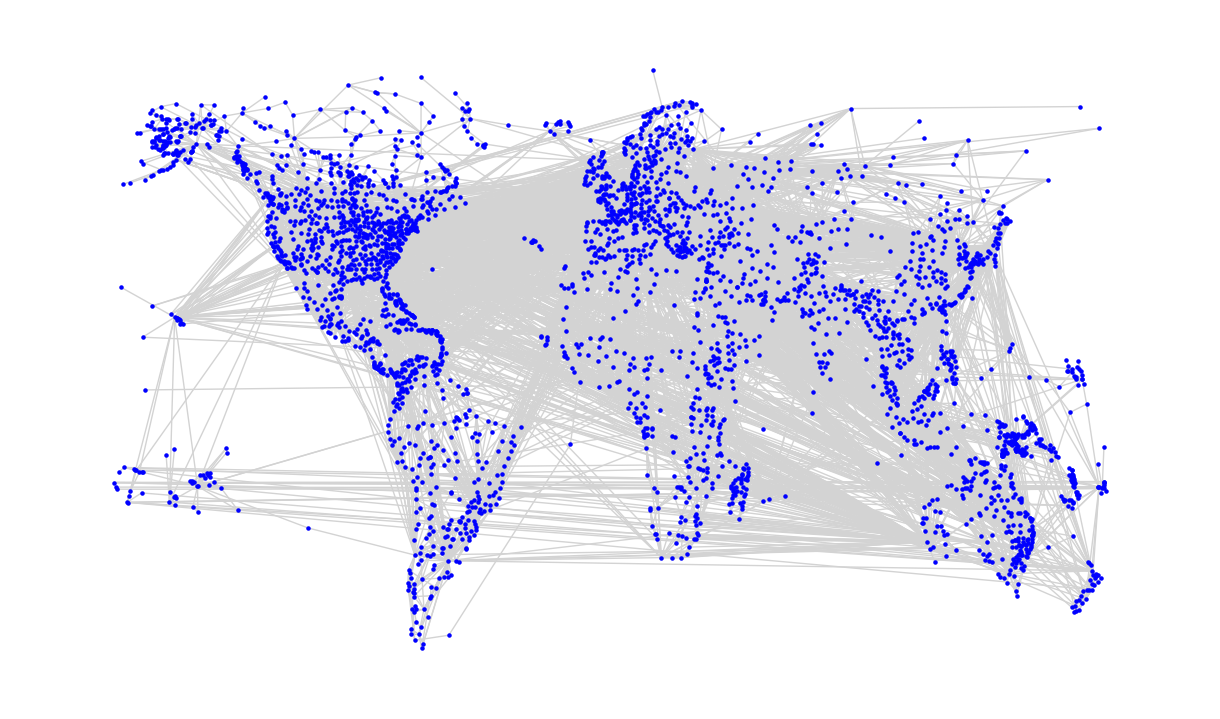

In [1]:
import matplotlib.pyplot as plt
import networkx as nx

def load_graph(min_nb_airport=1):
    # Load the graph from the graphml file
    g = nx.read_graphml("dataset/airportsAndCoordAndPop.graphml")
    countries = set([g.nodes[node]["country"] for node in g.nodes])
    countries = {country: sum([1 for node in g.nodes if g.nodes[node]["country"] == country]) for country in countries}
    g = g.subgraph([node for node in g.nodes if countries[g.nodes[node]["country"]] >= min_nb_airport])    
    return g


def plot_graph(g: nx.Graph, **kwargs):
    pos = {node: (g.nodes[node]["lon"], g.nodes[node]["lat"]) for node in g.nodes}
    args = {
            "pos": pos,
            "node_size": 5,
            "cmap": "tab20",
            "node_color": "blue",
            "edge_color": "lightgray",
            "with_labels": False,

        }
    
    for k, v in kwargs.items():
        args[k] = v
    
    plt.figure(figsize=(12, 7))
    nx.draw(g, **args)
    plt.show()
    
graph = load_graph()
print(f"Nb nodes: {len(graph.nodes)}")
print(f"Nb edges: {len(graph.edges)}")
plot_graph(graph)

In [2]:
def convert_fc(g: nx.Graph):
    new_graph = g.copy()
    new_graph.remove_edges_from(g.edges)
    edges = list(set([tuple(sorted([n1, n2])) for n1 in new_graph.nodes for n2 in new_graph.nodes if n1 != n2]))
    new_graph.add_edges_from(edges)
    # clean the graph
    new_graph.remove_edges_from(nx.selfloop_edges(new_graph))
    new_graph.remove_nodes_from(list(nx.isolates(new_graph)))
    
    return new_graph
    
graph = load_graph()
graph = convert_fc(graph)
print(f"Nb nodes: {len(graph.nodes)}")
print(f"Nb edges: {len(graph.edges)}")

Nb nodes: 3363
Nb edges: 5653203


In [5]:
def haversine(lat1, lon1, lat2, lon2):
    import math

    R = 6371  # radius of the Earth in km
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    return R * c

def add_distance(g: nx.Graph) -> nx.Graph:
    new_graph = g.copy()
    for edge in new_graph.edges:
        n1, n2 = edge
        new_graph.edges[edge]["distance"] = haversine(
            new_graph.nodes[n1]["lat"],
            new_graph.nodes[n1]["lon"],
            new_graph.nodes[n2]["lat"],
            new_graph.nodes[n2]["lon"],
        )
        
    return new_graph

print("Loading graph...", end="\t")
graph = load_graph()
print("[DONE]")
print("Convert to fully connected...", end="\t")
graph = convert_fc(graph)
print("[DONE]")
print("Add haversine distance...", end="\t")
graph = add_distance(graph)
print("[DONE]")

# Save graph
nx.write_graphml(graph, "dataset/graph-fc.graphml")



Loading graph...	[DONE]
Convert to fully connected...	[DONE]
Add haversine distance...	[DONE]


In [2]:
import networkx as nx

def load_fc_graph(nb_airport=1):
    g = nx.read_graphml("dataset/graph-fc.graphml")
    countries = set([g.nodes[node]["country"] for node in g.nodes])
    countries = {country: sum([1 for node in g.nodes if g.nodes[node]["country"] == country]) for country in countries}
    g = g.subgraph([node for node in g.nodes if countries[g.nodes[node]["country"]] >= nb_airport])
    return g

graph = load_fc_graph()
print(f"Nb nodes: {len(graph.nodes)}")
print(f"Nb edges: {len(graph.edges)}")

Nb nodes: 3363
Nb edges: 5653203


In [3]:
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx
import torch
import networkx as nx
from sklearn.preprocessing import LabelEncoder, StandardScaler

def prepare_data(g: nx.Graph, train_ratio=0.8, test_ratio=0.2):
    # Convert the networkx graph to a PyG Data object
    data = from_networkx(g, group_node_attrs=["lat", "lon", "population"])   
    # Edge weights
    data.edge_attr = torch.tensor(data.distance.reshape(-1, 1), dtype=torch.float)

    # Y (target) - Encode the country attribute as a tensor of longs 
    encoder = LabelEncoder()
    country_tensor = torch.tensor(encoder.fit_transform(data.country), dtype=torch.long)
    data.y = country_tensor
    data.num_classes = len(encoder.classes_)
    
    # Normalize the features
    scaler = StandardScaler()
    data.x = torch.tensor(scaler.fit_transform(data.x), dtype=torch.float)
    
    # Normalize edge weights (between 0 and 1)
    scaler = StandardScaler()
    data.edge_attr = torch.tensor(scaler.fit_transform(data.edge_attr), dtype=torch.float)
    data.edge_attr = (data.edge_attr - min(data.edge_attr)) / (max(data.edge_attr) - min(data.edge_attr))
    
    # Création de mask pour les données d'entraînement, de validation et de test
    if train_ratio + test_ratio != 1:
        raise ValueError("train_ratio + test_ratio must be equal to 1")
    data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    # create random permutation
    for i in range(data.num_nodes):
        if torch.rand(1) < train_ratio:
            data.train_mask[i] = True
        else:
            data.test_mask[i] = True

    return data

data = prepare_data(graph)

/tmp/ipykernel_23208/1684068969.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data.edge_attr = torch.tensor(data.distance.reshape(-1, 1), dtype=torch.float)


In [4]:
print(f"""
{data}

Nodes: {data.num_nodes}
Edges: {data.num_edges}

Node Features: {data.num_node_features}
Edge Features: {data.num_edge_features}

Classes: {data.num_classes}

""")


Data(edge_index=[2, 11306406], country=[3363], city_name=[3363], distance=[11306406], x=[3363, 3], edge_attr=[11306406, 1], y=[3363], num_classes=212, train_mask=[3363], test_mask=[3363])

Nodes: 3363
Edges: 11306406

Node Features: 3
Edge Features: 1

Classes: 212




In [5]:
# Define a simple GCN model
import torch
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dim_in, dim_h)
        self.conv2 = GCNConv(dim_h, dim_h)
        self.conv3 = GCNConv(dim_h, dim_out)
        
    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_attr

        x = F.relu(self.conv1(x, edge_index, edge_weight))
        x = F.relu(self.conv2(x, edge_index, edge_weight))
        x = self.conv3(x, edge_index, edge_weight)
        return  F.log_softmax(x, dim=1)
    
    
    def fit(self, data, epochs=100, lr=0.01):
        optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=5e-4)
        loss_fct = torch.nn.CrossEntropyLoss()

        evol_acc = []
        evol_loss = []
        
        self.train()
        for e in range(epochs):     
            optimizer.zero_grad()
            out = self(data)
            loss = loss_fct(out[data.train_mask], data.y[data.train_mask])
            loss.backward()
            acc = self.accuracy(out[data.test_mask].argmax(dim=1), data.y[data.test_mask])
            optimizer.step()
            
            evol_acc.append(acc)
            evol_loss.append(loss.item())
                
            print(f"Epoch {e+1}/{epochs} - Loss: {loss.item():.4f} - Acc: {acc:.4f}", end="\r")
        return evol_acc, evol_loss

    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data)
        acc = self.accuracy(out.argmax(dim=1), data.y)
        return acc
            
    def predict(self, data):
        self.eval()
        with torch.no_grad():
            out = self(data)
            return out.argmax(dim=1)
        
    def accuracy(self, pred, target):
        correct = pred.eq(target).sum().item()
        return correct / target.size(0)

In [ ]:
gcn = GCN(data.num_node_features, 16, data.num_classes)
evol_acc, evol_loss = gcn.fit(data, epochs=1000, lr=0.01)
acc = gcn.test(data)
print(f"\nAccuracy: {acc:.4f}")

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(evol_acc)
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(evol_loss)
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.show()